In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import bisect

class AssetDynamics:
    def __init__(self, s0, dt, mu, vol):
        self.s = s0
        self.dt = dt
        self.mu = mu
        self.vol = vol
        self.t = 0
        self.bid_spread = 50 / 10000
        self.ask_spread = 50 / 10000
    def evolve(self):
        self.s *= np.exp(self.mu * self.dt - 0.5*self.vol**2*self.dt + self.vol*self.dt**0.5*np.random.normal())
        self.t += self.dt
    def bid_price(self):
        return self.s *(1 + self.bid_spread)
        
    def ask_price(self):
        return self.s *(1 + self.ask_spread)
        

class Pnl:
    def __init__(self):
        self.spread = 0
        self.inventory = 0
        self.hdg = 0
    def total_pnl(self):
        return self.spread + self.inventory + self.hdg
    def __str__(self):
        return 'spread: {}, inventory: {}, hdg: {}'.format(self.spread, self.inventory, self.hdg)
        
class Inventory:
    def __init__(self):
        self.units = 0
    def __str__(self):
        return 'inventory: {}'.format(self.units)
    
class OBEntry:
    def __init__(self, price, size, agent):
        self.price = price
        self.size = size
        self.agent = agent
        
class RFQ:
    def __init__(self, sign, size, investor):
        self.sign = sign
        self.size = size
        self.investor = investor
        
class Transaction:
    def __init__(self, sn, time, agent, investor, sign, size, price, spread):
        self.sn = sn # serial number
        self.time = time
        self.agent = agent
        self.investor = investor
        self.sign = sign
        self.size = size
        self.price = price
        self.spread = spread
    
if 0:
    class OrderBook:
        def __init__(self, security):
            self.security = security
            self.bids = []
            self.asks = []
        def stream_bid(self, price, size, agent):
            self.bids.append(OBEntry(price, size, agent))

        def stream_ask(self, price, size, agent):
            self.asks.append(OBEntry(price, size, agent))

        def stream_prices(self, obentries : list):
            b = filter(entries, lambda e :  e.size > 0)
            self.bids.extend(b)
            a = filter(entries, lambda e :  e.size < 0)
            self.asks.extend(a)

        def clear_streams():
            self.bids = []
            self.asks = []

        def RFQ_transact(rfq):
            #self.bids.sort(key=lambda entry : entry.price)
            #self.asks.sort(key=lambda entry : entry.price)
            matched_order = None
            if rfq.sign == 1:
                mathed_order = min(self.asks, key=lambda entry : entry.price)
            elif rfq.sign == -1:
                mathed_order = max(self.bids, key=lambda entry : entry.price)
            else:
                raise Exception()

            if matched_order:
                Transaction(sn=sn, time=self.t, agent=matched_order.agent, investor=rfq.investor, sign=rfq.sign, size=rfq.size, price=bo_price, spread=bo_spr)
    
        
class Engine:
    def __init__(self):
        self.exchange = None
        self.investors = []
        self.agents = []
        self.transactions = []
    def set_exchange(self, exchange):
        self.exchange = exchange
    def add_investor(self, investor):
        self.investors.append(investor)
    def add_agent(self, agent):
        self.agents.append(agent)
        
    def transactions_df(self):
        fields = ['sn', 'time', 'agent', 'investor', 'sign', 'size', 'price', 'spread']
        #tmp = [{'sn': getattr(f, 'sn')} for f in self.transactions]
        df = pd.DataFrame([{fn: getattr(f, fn) for fn in fields} for f in self.transactions])
        df.rename(inplace=True, columns={'spread':'spread_bp'}) 
        df['spread_bp'] = df['spread_bp']*10000
        return df
        
    def evolve(self):
        self.exchange.evolve()
    
    def execute_match(self):
        # Assume agents quote infinite size. TODO: implement diff sizes.
        bo_sprds = [a.quote_spreads(self.exchange) for a in self.agents]
        offer_sprds, bid_sprds = zip(*bo_sprds)
        bb_idx = np.argmin(bid_sprds)
        bo_idx = np.argmin(offer_sprds)
        bb_spr, bb_agent = bid_sprds[bb_idx], self.agents[bb_idx]
        bo_spr, bo_agent = bid_sprds[bo_idx], self.agents[bo_idx]
        bb_price = self.exchange.s - bb_spr
        bo_price = self.exchange.s + bo_spr
        
        # Investors
        trans = []
        sn = len(self.transactions)
        for i in self.investors:
            trd = i.gentrade()
            if trd:
                if trd.sign > 0: #Investor buys
                    tmp = Transaction(sn=sn, time=self.exchange.t, agent=bo_agent, investor=i, sign=-trd.sign, size=trd.size, price=bo_price, spread=bo_spr)
                elif trd.sign < 0: #Investor sells
                    tmp = Transaction(sn=sn, time=self.exchange.t, agent=bo_agent, investor=i, sign=-trd.sign, size=trd.size, price=bb_price, spread=bb_spr)
                else:
                    raise Exception()
                trans.append(tmp)
                sn += 1
                
        # execute (pnl)
        for t in trans:
            t.agent.inventory.units += -t.sign * t.size
            t.agent.pnl.spread += t.spread * t.size
            t.agent.transactions.append(t)
            
        self.transactions.extend(trans)
                
            
# =======================================
# ==========  INVESTORS =================
# =======================================
class Investor:
    id_counter = 0
    def __init__(self):
        self.uid = Investor.id_counter
        Investor.id_counter += 1
        arrival_intensity = 1
        self.arrival_dist = stats.poisson(arrival_intensity)
        buy_prob = 0.5
        self.dir_dist = stats.bernoulli(buy_prob)
        size_rate = 1.0
        self.size_dist = stats.expon(size_rate)
    def gentrade(self):
        if self.arrival_dist.rvs():
            sign = 2*self.dir_dist.rvs() - 1
            size = self.size_dist.rvs()
            return RFQ(sign, size, self)
        else:
            return None
    def __str__(self):
        return '{} {}'.format(type(self).__name__, self.uid)
        
# =======================================
# ==========  AGENTS ====================
# =======================================
        
class Agent:
    def __init__(self):
        self.inventory = Inventory()
        self.pnl = Pnl()
        self.transactions = []
    def quote_spreads():
        raise NotImplementedError()
        
class RandomAgent(Agent):
    id_counter = 0
    def __init__(self, eps_min, eps_max):
        Agent.__init__(self)
        self.uid = RandomAgent.id_counter
        RandomAgent.id_counter += 1
        self.eps_buy_dist = stats.uniform(loc=eps_min, scale=eps_max - eps_min)
        self.eps_sell_dist = stats.uniform(loc=eps_min, scale=eps_max - eps_min)
        self.hdgfrac_dist = stats.uniform(loc=0, scale=1)
    def quote_spreads(self, exchange):
        # Agent's streamed bid
        si_bid = exchange.bid_spread * (1 + self.eps_buy_dist.rvs())
        
        # Agent's streamed bid
        si_ask = exchange.ask_spread * (1 + self.eps_sell_dist.rvs())
        return (si_bid, si_ask)
    
    def __str__(self):
        return type(self).__name__ + ' ' + str(self.uid)
        
class PersistentAgent(Agent):
    id_counter = 0
    def __init__(self, eps_buy, eps_sell, hdgfrac):
        Agent.__init__(self)
        self.uid = RandomAgent.id_counter
        RandomAgent.id_counter += 1
        self.eps_buy = eps_buy
        self.eps_sell = eps_sell
        self.hdgfrac = hdgfrac
    def quote_spreads(self, exchange):
        si_bid = exchange.bid_spread * (1 + self.eps_buy)
        si_ask = exchange.ask_spread * (1 + self.eps_sell)
        return (si_bid, si_ask)
    
    def __str__(self):
        return type(self).__name__ + ' ' + str(self.uid)
        
        
# =======================================
# ============  INIT ====================
# =======================================
        
invtrs = [Investor()]
ag1 = PersistentAgent(eps_buy=0.0, eps_sell=0.0, hdgfrac=0)
ag2 = RandomAgent(eps_min=-0.5, eps_max=0.5)
ag3 = RandomAgent(eps_min=-1.0, eps_max=1.0)
agnts = [ag1, ag2, ag3]

engine = Engine()
exchange = AssetDynamics(s0=100, dt=1, mu=0, vol=0.000000001)
engine.set_exchange(exchange)
for i in invtrs:
    engine.add_investor(i)
for a in agnts:
    engine.add_agent(a)

#matchingEngine = MatchingEngine()
# =======================================
# =============  RUN ====================
# =======================================
for i in range(1, 20):
    # 1. Each Agent Publishes prices
    engine.execute_match()
    engine.evolve()

    
# =======================================
# ============  RESULTS =================
# =======================================
for a in agnts:
    print('==========')
    print(str(a))
    print(a.inventory)
    print(a.pnl)

print(' ========================')
print(' ===== TRANSACTIONS =====')
print(engine.transactions_df().round({'price': 4, 'size':2, 'spread_bp':2}))


# Test if coin bias has changed

$X_i \sim Bin(n_i,p_i)$

$\hat{p}_i = \frac{X_i}{n_i}$

Consider the change in hit ratio $D = \hat{p}_1 - \hat{p}_2$

with central sampling moments
$\mu_D = p_1 - p_2$

$\sigma^2_D = \frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}$

$\mathcal{H}_0: \mu_D = 0$

$\sigma^2_D = \hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})$, with $\hat{p} = \frac{\hat{p}_1n_1 + \hat{p}_2n_2}{n_1 + n_2}$

$\mathcal{H}_1: \mu_D < 0$


The test statstic (under H0) is
$T = \frac{D-0}{\sigma_D}$ which for large samples follows a standard normal distribution.

The null hypothesis will be rejected if
$T > r$ where $r=\Phi^{-1}[1-\alpha]$

## Sample size and test power

To calculate the power of the test, we need to chose a specific alternative hypothesis.
Let's assume that the alternative hypothesis $\mathcal{H}_1: \mu_D = \theta$ is true.

$B(\theta) = 1 - \beta = Pr(T>r | \mathcal{H}_1) = 1-Pr(D < r - \frac{\theta}{\sigma_D}) = 1 - \Phi[r-\frac{\theta}{\sigma_D}]$

For a given value of $\alpha$, $ffkfkkfkf$

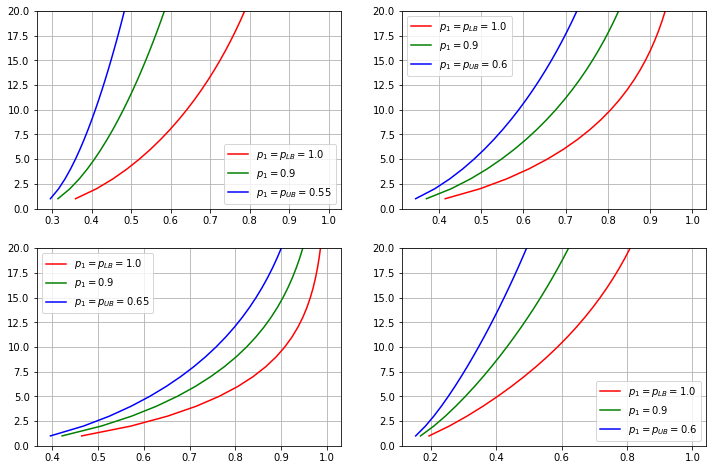

In [20]:
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np        
        
class TestPower:
    def __init__(self, beta, p1, p2, theta):
        self.beta = beta
        self.p1 = p1
        self.p2 = p2
        self.theta = theta
    def power(self, x):
        return 1 - self.beta(x)
        
        
def test_power(alpha, theta, p):
    r = stats.norm.ppf(1 - alpha)
    def std_up(n1, n2, p1, p2):
        return np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    def std_p(n1, n2, p1, p2):
        p = (p1*n1 + p2*n2) / (n1 + n2)
        return np.sqrt(p*(1-p)* (1/n1 + 1/n2))
    
    def beta(p1, p2, n1, n2):
        nom = r * std_p(n1,n2,p1,p2) - theta
        denom = std_up(n1, n2, p1, p2)
        return stats.norm.cdf(nom / denom)
    
    if isinstance(p, str):
        if p.upper() == 'LB':
            p1 = 1.0
        elif p.upper() == 'UB':
            p1 = 0.5 + theta/2
        else:
            raise ValueError()
    else:
        p1 = p
            
    p2 = p1 - theta
    return TestPower(beta = lambda x : beta(p1, p2, x, x), p1=p1, p2=p2, theta=theta)

xx = np.arange(100) + 1
fig, axs = plt.subplots(2, 2, figsize=(12,8))

def plot_quadrant(axis, pwr):
    axis.plot(pwr[0].power(xx), xx, color='r', label='$p_1=p_{{LB}}=1.0$')
    axis.plot(pwr[1].power(xx), xx, color='g', label='$p_1={}$'.format(pwr[1].p1))
    axis.plot(pwr[2].power(xx), xx, color='b', label='$p_1=p_{{UB}}={}$'.format(pwr[2].p1))

p = ['LB', 0.9, 'UB']
pwr = [test_power(alpha=0.25, theta=0.1, p = x) for x in p]
plot_quadrant(axs[0,0], pwr)

pwr = [test_power(alpha=0.25, theta=0.2, p = x) for x in p]
plot_quadrant(axs[0,1], pwr)

pwr = [test_power(alpha=0.25, theta=0.3, p = x) for x in p]
plot_quadrant(axs[1,0], pwr)

#pwr = [test_power(alpha=0.25, theta=0.4, p = x) for x in p]
pwr = [test_power(alpha=0.1, theta=0.2, p = x) for x in p]
plot_quadrant(axs[1,1], pwr)

for ax in axs.flatten():
    ax.grid()
    ax.legend()
    ax.set_ylim([0, 20])

#axs[0,0].plot(xx, ub(xx), color='r', label='$p_1=p_{{UB}}=1.0$')
#axs[0,0].plot(xx, mid(xx), color='b', label='$p_1=0.9$')
#axs[0,0].plot(xx, lb(xx), color='g', label='$p_1=p_{{LB}}={}$'.format(p_stdUB))
#axs[0,0].set_ylim([0, 1])
#plt.legend(fontsize=15)
#plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.grid()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


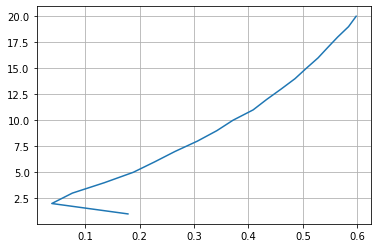

In [27]:

p1 = 0.9
theta = 0.1
p2 = p1 - theta

H0_true = (p1 == p2)


alpha = 0.1

taildir = np.sign(p2-p1)
r = stats.norm.ppf(1 - alpha)
dist1 = stats.bernoulli(p1)
dist2 = stats.bernoulli(p2)


def std_H0(x1, n1, x2, n2):
    p1 = x1/n1
    p2 = x2/n2
    p_pool = (p1*n1 + p2*n2) / (n1 + n2)
    return (p_pool*(1-p_pool) * (1/n1 + 1/n2))**0.5

def std_H1(x1, n1, x2, n2):
    p1 = x1/n1
    p2 = x2/n2
    return (p1*(1-p1) / n1 + p2*(1-p2) / n2)**0.5

nsim = 5000

n_max = 20
iota = np.arange(n_max) + 1
pr_rej = np.zeros(n_max)
for i in range(nsim):
    x1 = dist1.rvs(n_max)
    x2 = dist2.rvs(n_max)
    
    p1h = np.cumsum(x1) / iota
    p2h = np.cumsum(x2) / iota
    
    d = taildir*(p2h - p1h)
    
    z0 = d / std_H0(x1, iota, x2, iota)
    #z1 = d / std_H1(x1, iota, x2, iota)
    pr_rej += 1*(z0 > stats.norm.ppf(1-alpha))

if 0:
    if H0_true:
        print('False pos (alpha): {}'.format(pr_rej / nsim))
    else:
        print('Power: {}'.format(pr_rej / nsim))
        print('beta: {}'.format(1-pr_rej / nsim))
    
plt.plot(pr_rej/nsim, iota)
plt.grid()
plt.show()

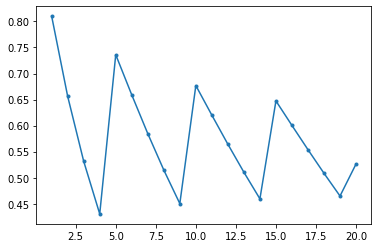

In [39]:

p1 = 0.9
theta = 0.8
p2 = p1 - theta
taildir = np.sign(p2-p1)
nn = np.arange(20) + 1
data = np.zeros(nn.shape[0])
for i,n in enumerate(nn):
    n1 = n2 = n
    for k1 in range(n1+1):
        for k2 in range(n2+1):
            if taildir*(k2/n2 - k1/n1) >= theta:
                data[i] += stats.binom.pmf(k1, n1, p1) * stats.binom.pmf(k2, n2, p2)

plt.plot(nn, data, marker='.')
plt.show()